# Learning 

[Video link](https://www.youtube.com/watch?v=nN0OD6HLDJk&feature=youtu.be)

[Article link](https://towardsdatascience.com/if-you-like-to-travel-let-python-help-you-scrape-the-best-fares-5a1f26213086)

The idea of the structure is more or less like this:

* a function will start the bot, declaring the cities and dates we want to search
* this function gets the first search results, sorted by “best” flights, and clicks the “load more results”
* another function will scrape the whole page, and return a dataframe
* it will repeat step 2 and 3 for the “cheap” and “fastest” sort types
* an email will be sent to you with a brief summary of the prices (cheapest and average), and the dataframe with the three sort types will be saved as an excel file
* all the previous steps are repeated in a loop, that runs every X hours.

## webscraping

[ChromeDriver](http://chromedriver.chromium.org/)

Download and store in project folder

In [105]:
from time import sleep, strftime
import datetime
import time
import numpy as np
import scipy.interpolate as si

#from random import randint
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains

import smtplib
from email.mime.multipart import MIMEMultipart

Should open a blank page as a test:

In [108]:
chromedriver_path='C:/Users/roddt/Desktop/flights/chromedriver/download/chromedriver.exe'
driver = webdriver.Chrome(executable_path=chromedriver_path) # This will open the Chrome window
action =  ActionChains(driver)
sleep(2)

### get our sample page
go to kayak and select a sample city...let's say Atlanta to Belfast...I think that's where Anthony is.

The code below should take our empty browser from the block before and open it to the kayak link.

In [109]:
belfast = "https://www.kayak.com/flights/ATL-BFS/2019-09-17-flexible-2day/2019-09-25-flexible-1day?sort=bestflight_a"
driver.get(belfast)
sleep(3)

Now search the html with a **XPath selector**

...*"It searches for an element a which has an attribute data-code equal to 'price'"*

'Inspect' the page to verify your selection

In [16]:
cheap_results = '//a[@data-code = "price"]'
driver.find_element_by_xpath(cheap_results).click()

...weird, in the article they use xpath stuff but really you could have just changed the kayak link from ```?sort=bestflight_a``` to ```?sort=price_a``` ...there's also by time ```?sort=duration_a```

https://www.kayak.com/flights/ATL-BFS/2019-09-06-flexible-1day/2019-09-09-flexible-1day?sort=price_a

*"Each result is inside an object with the class 'resultWrapper'."*

fetch over a for loop

In [17]:
xp_results_table = '//*[@class = "resultWrapper"]'
flight_containers = driver.find_elements_by_xpath(xp_results_table)
flights_list = [flight.text for flight in flight_containers]

In [18]:
print(len(flights_list), "flights on 1 page")
flights_list[:3]

15 flights on 1 page


['Rating:\n0\n9/7\nSat\n5:45 pm — 8:35 pm +1\nMultiple Airlines\n2 stops\nTPA, LGW\n21h 50m\nATL ‐ BFS\n9/9\nMon\n2:00 pm — 4:42 pm +1\nMultiple Airlines\n2 stops\nCDG, EWR\n31h 42m\nBFS ‐ ATL\nOperated by Norwegian Air UK\n0\n0\n$724\nKiwi.com\nView Deal',
 'Rating:\n0\n9/5\nThu\n3:05 pm — 6:00 pm +1\nMultiple Airlines\n2 stops\nFLL, CDG\n21h 55m\nATL ‐ BFS\n9/9\nMon\n2:00 pm — 2:30 pm +1\nMultiple Airlines\n3 stops\nCDG, EWR, ...\n29h 30m\nBFS ‐ ATL\n0\n1\n$727\nKiwi.com\nView Deal',
 'Rating:\n0\n9/7\nSat\n5:45 pm — 5:50 pm +1\nMultiple Airlines\n2 stops\nTPA, LGW\n19h 05m\nATL ‐ BFS\n9/10\nTue\n2:00 pm — 6:03 pm +1\nMultiple Airlines\n2 stops\nCDG, EWR\n33h 03m\nBFS ‐ ATL\nOperated by Norwegian Air UK\n0\n0\n$728\nKiwi.com\nView Deal']

### a sample flight info
Let's look at a single element and see what we can get from it

In [22]:
print(flights_list[0])
one_flight = flights_list[0].split("\n")

print("\n%i elements per flight" %(len(one_flight)))

Rating:
0
9/7
Sat
5:45 pm — 8:35 pm +1
Multiple Airlines
2 stops
TPA, LGW
21h 50m
ATL ‐ BFS
9/9
Mon
2:00 pm — 4:42 pm +1
Multiple Airlines
2 stops
CDG, EWR
31h 42m
BFS ‐ ATL
Operated by Norwegian Air UK
0
0
$724
Kiwi.com
View Deal

24 elements per flight


So this gives the round trip info...

* first the ranking by how we ```?sort=```
* info on the set of flights to the destination
* info on the set of flights back home
* a final block on all meta data

Note that the departure/arrival flight blocks begin with a numerical date (month/date) and end with the airport codes (ATL - destination ... destination - ATL)

## bring it all together
Okay let's figure out a plan to parse future dates and set up the kayak link

I thought about also building a dictionary of city name to airport codes but it's prob just faster to let the user google that info

In [83]:
def build_kayak_link(home="ATL", destination=None,
                     depart_date=None, return_date=None,
                     depart_dow=None, return_dow=None, num_weeks=None,
                     flexible=None,
                     sort=None):
    '''
    trying to mimic this...
    https://www.kayak.com/flights/ATL-BFS/2019-09-06-flexible-1day/2019-09-09-flexible-1day?sort=price_a
    
    * the dates can be explicit yyyy-mm-dd
    * could also give day of the week and will search that day of the week for the next #ofweeks
    * I JUST REALIZED THAT THIS ONLY WORKS IF YOUR DEPART DOW IS TOWARDS END OF THE WEEK AND RETURN IS EARLY
    * flexible needs to be an int [1,2,3]
    * sort needs to be ["price","best","time"]
    '''
    if (depart_date is not None) and (return_date is not None):
        departs = [depart_date]
        returns = [return_date]
    elif (depart_dow is not None) and (return_dow is not None) and (type(num_weeks) is int):
        dow = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
        assert ((depart_dow in dow) and (return_dow in dow)), "wrong dow; make sure to capitalize"
        # let's make it a standard to look 2 weeks ahead and round up
        # get dow in a format that datetime object will understand
        today = datetime.datetime.today()
        depart_dow = int(np.argwhere(depart_dow==np.array(dow))[0,0]) # super ugly, sorry
        return_dow = int(np.argwhere(return_dow==np.array(dow))[0,0])
        if depart_dow < return_dow:
            trip_days = return_dow - depart_dow
        elif depart_dow > return_dow:
            trip_days = (7-depart_dow) + return_dow
        else:
            trip_days = 7
        if today.weekday() <= depart_dow:
            index_date = today + datetime.timedelta(weeks=2, days=depart_dow-today.weekday())
        else: #today.weekday() > depart_dow
            index_date = today + datetime.timedelta(weeks=2, days=7-today.weekday()+depart_dow)
        departs = []
        returns = []
        for w in range(num_weeks):
            depart_datetime = index_date + datetime.timedelta(weeks=w)
            departs.append(depart_datetime.strftime('%Y-%m-%d'))
            returns.append((depart_datetime+datetime.timedelta(days=trip_days)).strftime('%Y-%m-%d'))
    else:
        print("User Error: gave incomplete date information")
        return 0
    
    assert ((type(home) is str) and (type(destination) is str)), "invalid value for home/destination"
    assert ((sort is None) or (sort in ["price", "best", "time"]))
    sort_valid_values = {
        None : "bestflight_a",
        "price" : "price_a",
        "best" :  "bestflight_a",
        "time" : "duration_a"
    }
    
    urls = []
    for dep, ret in zip(departs, returns):
        if flexible is None:
            url = "https://www.kayak.com/flights/%s-%s/%s/%s?sort=%s" % (
                        home, destination,
                        dep, ret,
                        sort_valid_values[sort])
        else:
            assert (flexible in [1,2,3]), "invalid value for 'flexible'"
            url = "https://www.kayak.com/flights/%s-%s/%s-flexible-%iday/%s-flexible-%iday?sort=%s" % (
                        home, destination, 
                        dep, ret,
                        flexible, flexible,
                        sort_valid_values[sort])
        urls.append(url)
    
    return urls

In [3]:
def get_to_url(url, driver):
    driver.get(url); sleep(5)
    sleep(3)
    xp_results_table = '//*[@id = "px-captcha"]'
    captcha = driver.find_elements_by_xpath(xp_results_table)
    attempt = 0; sleeping = 0
    while captcha:
        attempt += 1
        print("Caught Captcha - attempt %i - %s" % (attempt, datetime.datetime.now().time()))
        driver.get("https://www.reddit.com/r/travel/")
        sleeping += randint(20,60); print("...waiting %isec" % sleeping)
        sleep(sleeping)
        driver.get(url); sleep(5)
        captcha = driver.find_elements_by_xpath(xp_results_table)
    print("Completed")
    # check if this is a captcha page

In [5]:
belfast = "https://www.kayak.com/flights/ATL-BFS/2019-09-15-flexible-1day/2019-09-25-flexible-1day?sort=bestflight_a"
driver.get(belfast)
sleep(3)
#get_to_url(belfast,driver)

In [163]:
# random filters to click
def click_filter(driver):
    start_time = time.time()
    
    xp_results_table = '//*[@class = "filterSectionTitle"]'
    flight_containers = driver.find_elements_by_xpath(xp_results_table)
    action =  ActionChains(driver)
    i = randint(0,len(flight_containers))
    try:    
        action.move_to_element(flight_containers[i])
        flight_containers[i].click()
        print("success")
    except:
        print("trying again")
        click_filter(driver)
        return
        
    sleep(np.random.random()*5)
    print("random clicking - %.2fsec" % (time.time()-start_time))
    return

In [164]:
click_filter(driver)

trying again
success
random clicking - 4.52sec


In [157]:
def move_mouse(driver, action, plot=False):
    '''
    https://stackoverflow.com/questions/39422453/human-like-mouse-movements-via-selenium
    https://github.com/guilhermebferreira/selenium-notebooks/blob/master/Mouse%20move%20by%20b-spline%20interpolation.ipynb
    '''
    start_time = time.time()
    
    # set up curve
    start = np.random.randint(-10,10+1,2) # STARTING LOCATION
    my_points = [start]
    length = np.random.randint(40,80) # NUMBER OF MOVEMENTS
    for i in range(length//5):
        new = my_points[-1] + np.random.randint(-200,200+1,2) # STEP SIZES
        my_points.append(new)
    my_points = np.array(my_points)
    x = my_points[:,0]
    y = my_points[:,1]
    t = range(len(my_points))
    ipl_t = np.linspace(0.0, len(my_points) - 1, length) # FINAL NUMBER OF MOVEMENTS
    x_tup = si.splrep(t, x, k=3)
    y_tup = si.splrep(t, y, k=3)
    x_list = list(x_tup)
    xl = x.tolist()
    x_list[1] = xl + [0.0, 0.0, 0.0, 0.0]
    y_list = list(y_tup)
    yl = y.tolist()
    y_list[1] = yl + [0.0, 0.0, 0.0, 0.0]
    x_i = si.splev(ipl_t, x_list)
    y_i = si.splev(ipl_t, y_list)
    if plot:
        import matplotlib.pyplot as plt
        plt.scatter(start[0],start[1])
        plt.plot(x_i,y_i)

    #decide starting location
    coin_flip = np.random.choice(["by_code","by_dealbutton"])
    if coin_flip == "by_code":
        code = np.random.choice(['price','bestflight','duration'])
        xpath = '//a[@data-code = "%s"]' % code
        startElement = driver.find_element_by_xpath(xpath)
    elif coin_flip == "by_dealbutton":
        xpath = '//*[@class = "booking-link"]'
        startElement = np.random.choice(driver.find_elements_by_xpath(xpath))
    else:
        print("whut, how?")
    action =  ActionChains(driver)
    action.move_to_element(startElement)
    try:
        action.perform()
    except:
        print("failed to get to starting location")
        print("...%s - %s" % (coin_flip, startElement.text))
        sleep(5)
    
    # perform mouse movement
    for m, (mouse_x, mouse_y) in enumerate(zip(x_i,y_i)):
        if (plot) and (m%10==0): print(m)
        try:
            action.move_by_offset(mouse_x,mouse_y)
            action.perform()
        except Exception as e:
            #print(mouse_x,mouse_y, e)
            pass
        sleep(np.random.random()*.1)
    
    print("mouse movements - %.2fsec" % (time.time()-start_time))

In [158]:
move_mouse(driver, action, plot=False)

KeyboardInterrupt: 

In [154]:
help(action.move_by_offset)

Help on method move_by_offset in module selenium.webdriver.common.action_chains:

move_by_offset(xoffset, yoffset) method of selenium.webdriver.common.action_chains.ActionChains instance
    Moving the mouse to an offset from current mouse position.
    
    :Args:
     - xoffset: X offset to move to, as a positive or negative integer.
     - yoffset: Y offset to move to, as a positive or negative integer.



In [56]:
points = [[-6, 2], [-3, -2],[0, 0], [0, 2], [2, 3], [4, 0], [6, 3], [8, 5], [8, 8], [6, 8], [5, 9], [7, 2]]
points = np.array(points)
x = points[:,0]
y = points[:,1]
t = range(len(points))
ipl_t = np.linspace(0.0, len(points) - 1, 100)
x_tup = si.splrep(t, x, k=3)
y_tup = si.splrep(t, y, k=3)
x_list = list(x_tup)
xl = x.tolist()
x_list[1] = xl + [0.0, 0.0, 0.0, 0.0]
y_list = list(y_tup)
yl = y.tolist()
y_list[1] = yl + [0.0, 0.0, 0.0, 0.0]
x_i = si.splev(ipl_t, x_list)
y_i = si.splev(ipl_t, y_list)

In [83]:
code = np.random.choice(['price','bestflight','duration','depart','arrive'])
xpath = '//a[@data-code = "%s"]' % code
startElement = driver.find_element_by_xpath(xpath)


In [ ]:
start = np.random.randint(-10,10+1,2)
plt.scatter(start[0],start[1])
my_points = [start]
for i in range(np.random.randint(50,100)):
    new = my_points[-1] + np.random.randint(-4,4+1,2)
    my_points.append(new)
my_points = np.array(my_points)
x = my_points[:,0]
y = my_points[:,1]
t = range(len(my_points))
ipl_t = np.linspace(0.0, len(my_points) - 1, 2000)
x_tup = si.splrep(t, x, k=3)
y_tup = si.splrep(t, y, k=3)
x_list = list(x_tup)
xl = x.tolist()
x_list[1] = xl + [0.0, 0.0, 0.0, 0.0]
y_list = list(y_tup)
yl = y.tolist()
y_list[1] = yl + [0.0, 0.0, 0.0, 0.0]
x_i = si.splev(ipl_t, x_list)
y_i = si.splev(ipl_t, y_list)
plt.plot(x_i,y_i)

coin_flip = np.random.choice(["by_code","by_dealbutton","wildcard"])
if coin_flip == "by_code":
    code = np.random.choice(['price','bestflight','duration'])
    xpath = '//a[@data-code = "%s"]' % code
    startElement = driver.find_element_by_xpath(xpath)
elif coin_flip == "by_dealbutton":
    xpath = '//*[@class = "booking-link"]'
    startElement = np.random.choice(driver.find_elements_by_xpath(xpath))
else:
    print("whut, how?")
action =  ActionChains(driver)
action.move_to_element(startElement)
action.perform()

print("starting", datetime.datetime.now().time(), code)
for m, (mouse_x, mouse_y) in enumerate(zip(x_i,y_i)):
    if m%10==0: print(m)
    try:
        action.move_by_offset(mouse_x,mouse_y)
        action.perform()
    except Exception as e:
        print(mouse_x,mouse_y, e)
    sleep(np.random.random()*.1)
print("end loop", datetime.datetime.now().time())

In [98]:
xpath = '//*[@class = "booking-link"]'
startElement = np.random.choice(driver.find_elements_by_xpath(xpath))


In [99]:
startElement

<selenium.webdriver.remote.webelement.WebElement (session="5d3d0666afcc25125cda8876e848594a", element="08c07296-b4f9-4e7d-b59c-9915ae5a8afc")>

In [52]:
import matplotlib.pyplot as plt

In [57]:
x_n = x_i + np.random.random(len(x_i))
y_n = y_i + np.random.random(len(y_i))

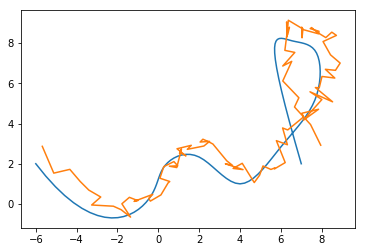

In [58]:
plt.plot(x_i,y_i)
plt.plot(x_n,y_n)

In [50]:
x_i[:50]+np.random.

array([-6.        , -5.50931642, -5.03749428, -4.58487654, -4.15180613,
       -3.73862597, -3.34567901, -2.97330818, -2.62185642, -2.29166667,
       -1.98308185, -1.6964449 , -1.43209877, -1.19038637, -0.97165066,
       -0.77623457, -0.60448102, -0.45673297, -0.33333333, -0.23365341,
       -0.15317787, -0.08641975, -0.02789209,  0.02789209,  0.08641975,
        0.15317787,  0.23365341,  0.33333333,  0.45633288,  0.60128029,
        0.7654321 ,  0.94604481,  1.14037494,  1.34567901,  1.55921353,
        1.77823503,  2.        ,  2.22222222,  2.44444444,  2.66666667,
        2.88888889,  3.11111111,  3.33333333,  3.55555556,  3.77777778,
        4.        ,  4.22222222,  4.44444444,  4.66666667,  4.88888889])

In [51]:
y_i[:50]

array([ 2.        ,  1.38176345,  0.85657674,  0.41872428,  0.06249047,
       -0.21784027, -0.42798354, -0.57365493, -0.66057004, -0.69444444,
       -0.68099375, -0.62593355, -0.53497942, -0.41384697, -0.26825179,
       -0.10390947,  0.07346441,  0.25815424,  0.44444444,  0.62753391,
        0.80627953,  0.98045267,  1.14982472,  1.31416705,  1.47325103,
        1.62684804,  1.77472946,  1.91666667,  2.05166895,  2.1756973 ,
        2.28395062,  2.3716278 ,  2.43392775,  2.46604938,  2.46319159,
        2.42055327,  2.33333333,  2.1998171 ,  2.03063557,  1.83950617,
        1.64014632,  1.44627343,  1.27160494,  1.12985825,  1.0347508 ,
        1.        ,  1.03543667,  1.13534522,  1.29012346,  1.49016918])

In [48]:
driver.find_element_by_id('drawer')

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[id="drawer"]"}
  (Session info: chrome=75.0.3770.142)


In [45]:
points = [[0, 0], [0, 2], [2, 3], [4, 0], [6, 3], [8, 2], [8, 0]];
points = np.array(points)

x = points[:,0]
y = points[:,1]

t = range(len(points))
ipl_t = np.linspace(0.0, len(points) - 1, 100)

x_tup = si.splrep(t, x, k=3)
y_tup = si.splrep(t, y, k=3)

In [46]:
x_tup

(array([0., 0., 0., 0., 2., 3., 4., 6., 6., 6., 6.]),
 array([-3.44265545e-18, -1.22222222e+00,  1.44444444e+00,  4.00000000e+00,
         6.55555556e+00,  9.22222222e+00,  8.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 3)

In [4]:
belfast = "https://www.kayak.com/flights/ATL-BFS/2019-09-12-flexible-1day/2019-09-25-flexible-2day?sort=bestflight_a"
get_to_url(belfast,driver)

Caught Captcha - attempt 1 - 17:51:52.724836
...waiting 25sec


KeyboardInterrupt: 

In [95]:
xp_results_table = '//*[@id = "px-captcha"]'
captcha = driver.find_elements_by_xpath(xp_results_table)
if captcha:
    print("DAMN DANIEL")
    driver.get("https://www.google.com")
    sleep(31.5)
    belfast = "https://www.kayak.com/flights/ATL-BFS/2019-09-18-flexible-1day/2019-09-25-flexible-1day?sort=bestflight_a"
    driver.get(belfast)

DAMN DANIEL


In [ ]:
cheap_results = '//a[@data-code = "price"]'
driver.find_element_by_xpath(cheap_results).click()

In [28]:
ting.id

'cb652225-bbfa-4b2e-a130-7a1ddc4a0b08'

In [37]:
click_filter(driver)

success


In [ ]:
You need to do this step by step checking the visibility of the elements you are going to interact with using Explicit Waits, do not use time.sleep() - it is not reliable and error-prone:

from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

driver = webdriver.Chrome()

driver.get("http://www.flipkart.com/watches/pr?p%5B%5D=facets.ideal_for%255B%255D%3DMen&p%5B%5D=sort%3Dpopularity&sid=r18&facetOrder%5B%5D=ideal_for&otracker=ch_vn_watches_men_nav_catergorylinks_0_AllBrands")
driver.maximize_window()

# wait for Men menu to appear, then hover it
men_menu = WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.XPATH, "//a[@data-tracking-id='men']")))
ActionChains(driver).move_to_element(men_menu).perform()

# wait for Fastrack menu item to appear, then click it
fastrack = WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.XPATH, "//a[@data-tracking-id='0_Fastrack']")))
fastrack.click()

In [85]:
urls = build_kayak_link(destination="BFS",depart_dow="Saturday", return_dow="Monday", num_weeks=2)

In [86]:
urls

['https://www.kayak.com/flights/ATL-BFS/2019-08-10/2019-08-12?sort=bestflight_a',
 'https://www.kayak.com/flights/ATL-BFS/2019-08-17/2019-08-19?sort=bestflight_a']

In [74]:
print(ret)

['2019-08-12', '2019-08-19']


In [77]:
for a,b in zip(dep,ret):
    print(a,b)

2019-08-10 2019-08-12
2019-08-17 2019-08-19


In [29]:
xp_results_table = '//*[@id = "px-captcha"]'
captcha = driver.find_elements_by_xpath(xp_results_table)

In [30]:
if captcha: print("yup")

In [32]:
captcha = '//*[@class = "recaptcha-checkbox-border"]'
#//*[@id="recaptcha-anchor"]/div[1]
driver.find_element_by_xpath(captcha).click()

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@class = "recaptcha-checkbox-border"]"}
  (Session info: chrome=75.0.3770.142)
